# Hotel Chain Cancellation Ration

# Setup

In [1]:
!pip install sweetviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 54.4 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install boruta

In [3]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 8.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 15.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 84.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.2/185.2 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [55]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import xgboost           as xgb
import lightgbm          as lgb
import sweetviz          as sv

from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder
from sklearn.metrics         import f1_score
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from boruta                  import BorutaPy
from pycaret.classification  import *
from sklearn.preprocessing   import LabelEncoder


In [122]:
# Funções
# Elimina NAS
def fill_nas(df):
    # Substituir valores ausentes na coluna 'nacionalidade'
    df['nacionalidade'].fillna("Não informado", inplace=True)
    
    # Substituir valores ausentes na coluna 'hospedes' pela mediana
    median_hospedes = df['hospedes'].median()
    df['hospedes'].fillna(median_hospedes, inplace=True)

    return df

# Renomeia colunas
def rename_columns(df, column_mapping):
    return df.rename(columns=column_mapping)

# Encode de colunas binárias     
def processar_coluna_sim_nao(column):
    return column.apply(lambda x: 1 if x == 'Sim' else 0).astype('int64')

# Aplicando log
def aplicar_log1p(column):
    return np.log1p(column)

# Feature engineering hospodes
def classificar_hospede(nacionalidade):
    if nacionalidade == 'Spain':
        return 'nacional'
    elif nacionalidade in UE:
        return 'europeu'
    else:
        return 'internacional'

def encoder_df(df):
    # Ordinal encode para a coluna 'alimentacao'
    dict_alimentacao = {
        'Sem refeicao': 0,
        'Café da manha': 1,
        'Café da manha e jantar': 2,
        'Café da manha, almoco e jantar': 3
    }
    df['alimentacao'] = df['alimentacao'].map(dict_alimentacao)
    
    # Label encode para a coluna 'nacionalidade'
    paises = df['nacionalidade'].unique().tolist()
    labels_paises = {p: i+1 for i, p in enumerate(paises)}
    df['nacionalidade'] = df['nacionalidade'].map(labels_paises)
    
    # Label encode para a coluna 'tipo_de_quarto'
    le_tipo_de_quarto = LabelEncoder()
    df['tipo_de_quarto'] = le_tipo_de_quarto.fit_transform(df['tipo_de_quarto'])

    # Dados originais
    classificacao = df['classificacao']
    forma_da_reserva = df['forma_da_reserva']
    reserva_agencia = df['reserva_agencia']
    reserva_com_estac = df['reserva_com_estac']
    reserva_com_obs = df['reserva_com_obs']
    tipo_hospede = df['tipo_hospede']

    # Inicializar os codificadores
    label_encoders = {
        'classificacao': LabelEncoder(),
        'forma_da_reserva': LabelEncoder(),
        'reserva_agencia': LabelEncoder(),
        'reserva_com_estac': LabelEncoder(),
        'reserva_com_obs': LabelEncoder(),
        'tipo_hospede': LabelEncoder()
    }

    # Aplicar o label encoding em cada coluna
    encoded_data = {}
    for column, encoder in label_encoders.items():
        encoded_data[column] = encoder.fit_transform(eval(column))

    # Substituir as colunas originais pelos valores codificados
    for column, encoded_values in encoded_data.items():
        df[column] = encoded_values

    return df



In [6]:
# Carregar os dados do arquivo CSV em um DataFrame
file_path = '/kaggle/input/cdshackdays4/train.csv'
df = pd.read_csv(file_path)

In [27]:
# Dicionário para mapear os novos nomes das colunas
new_names = {
    'Classificação do hotel': 'classificacao',
    'Meses da reserva até o check-in': 'meses_para_reserva',
    'Número de pernoites reservadas': 'pernoites',
    'Número de hospedes': 'hospedes',
    'Regime de alimentação': 'alimentacao',
    'Nacionalidade': 'nacionalidade',
    'Forma de Reserva': 'forma_da_reserva',
    'Já se hospedou anterioremente': 'historico_hospedagem',
    'Tipo do quarto reservado': 'tipo_de_quarto',
    'Reserva feita por agência de turismo': 'reserva_agencia',
    'Reserva feita por empresa': 'reserva_empresa',
    'Reserva com Estacionamento': 'reserva_com_estac',
    'Reserva com Observações': 'reserva_com_obs',
    'Reserva Cancelada': 'reserva_cancelada'
}

# Aplicar renomeação das colunas no DataFrame
df1 = rename_columns(df, new_names)

                                             |          | [  0%]   00:00 -> (? left)


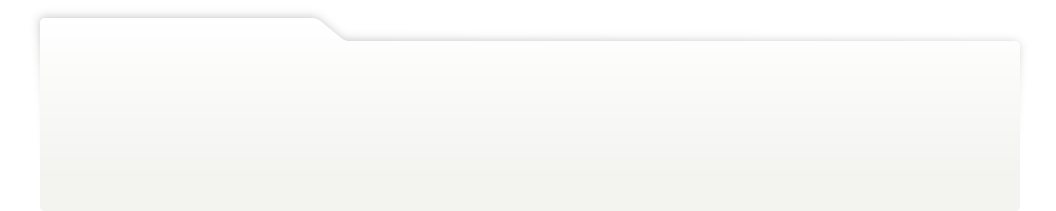
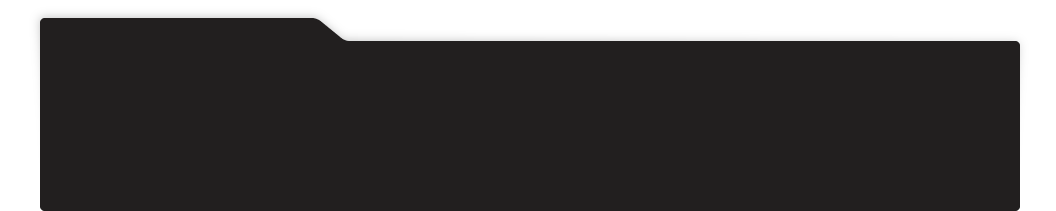
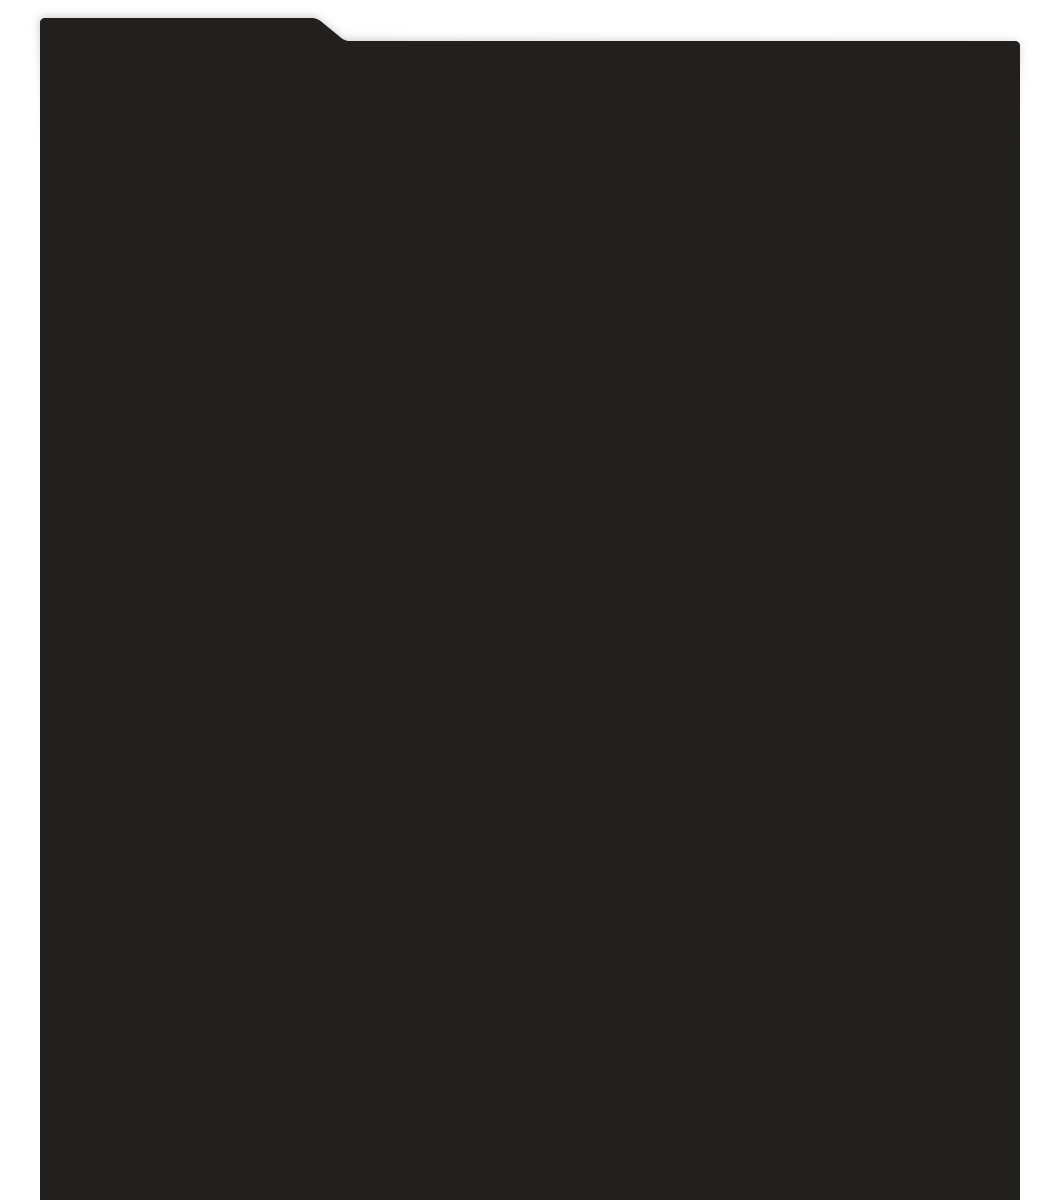
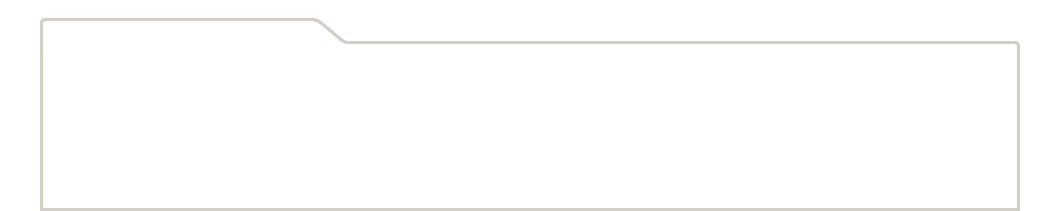
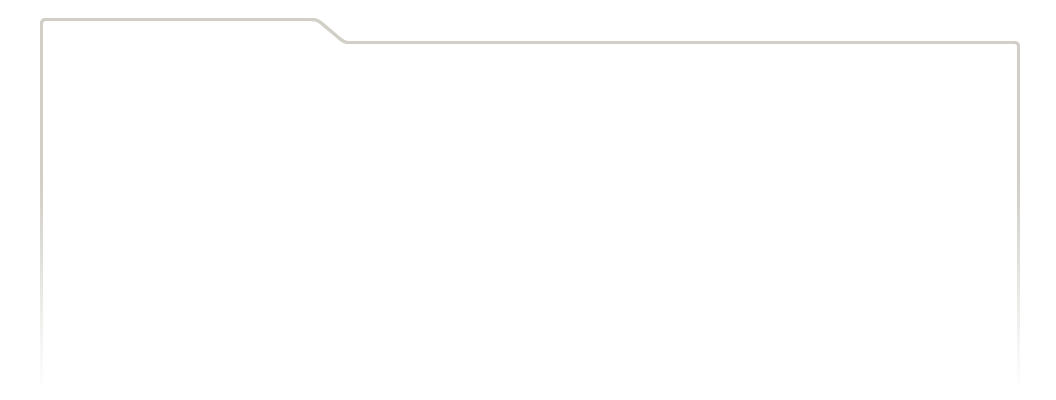
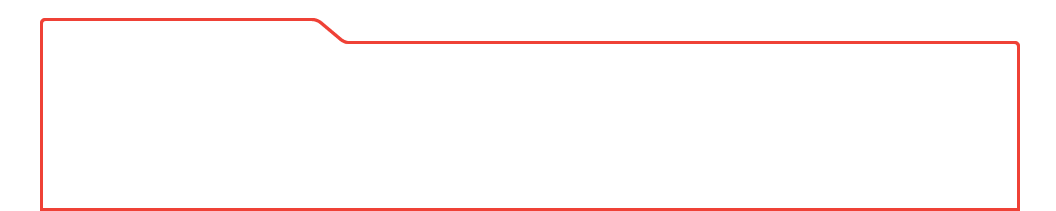
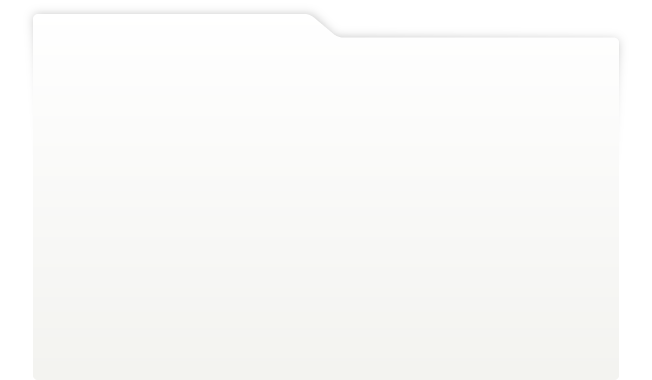
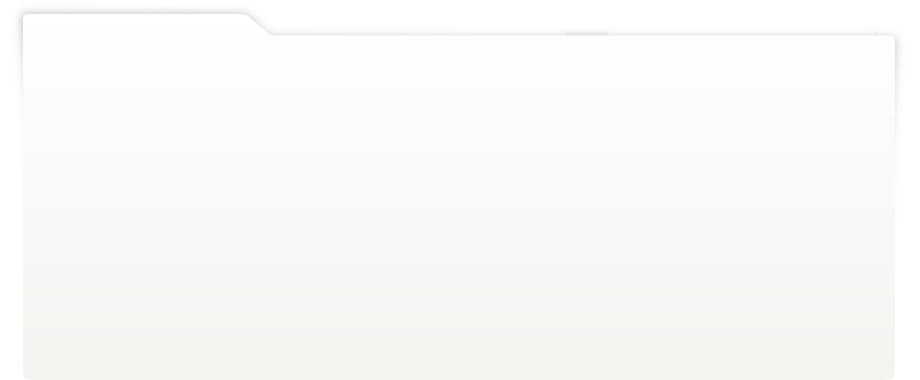
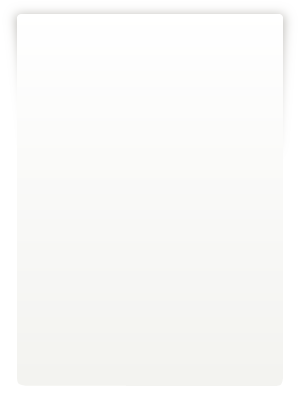
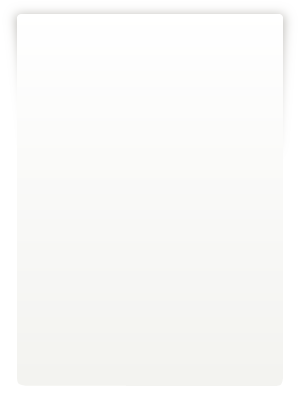
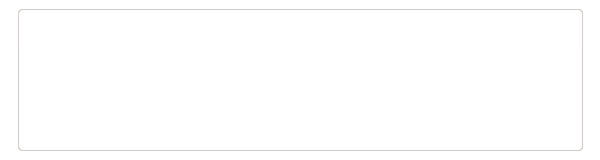
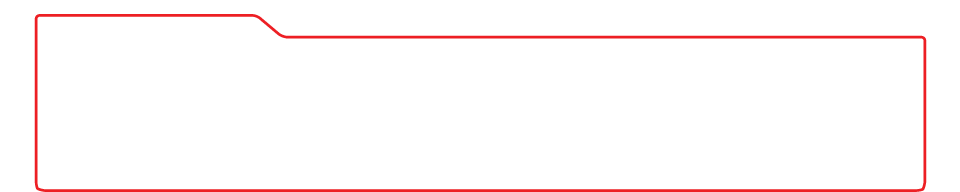
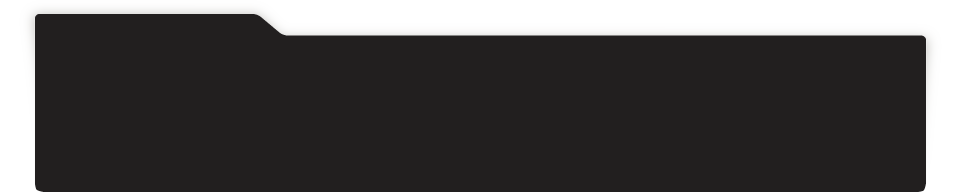
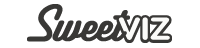
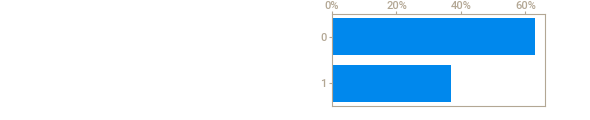
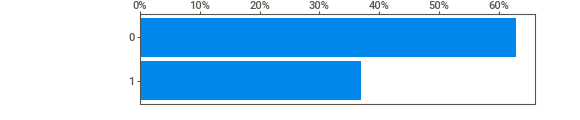
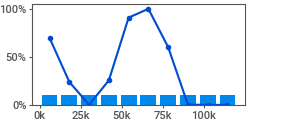
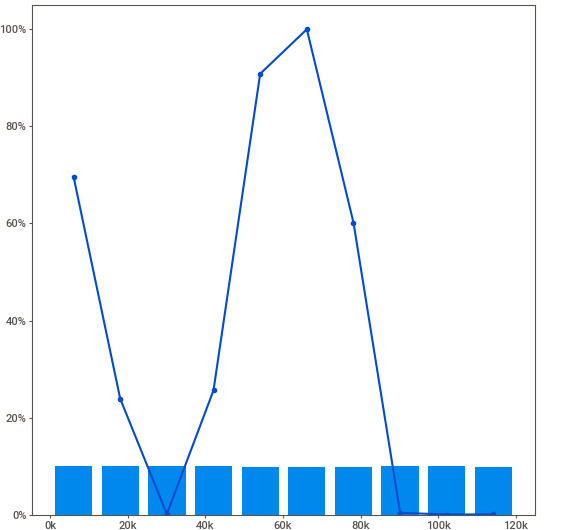
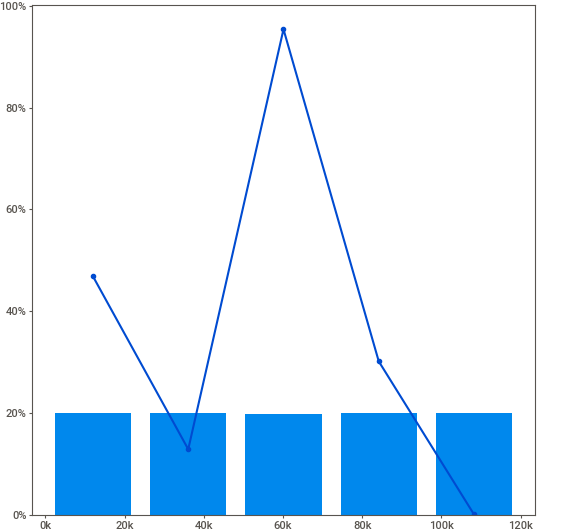
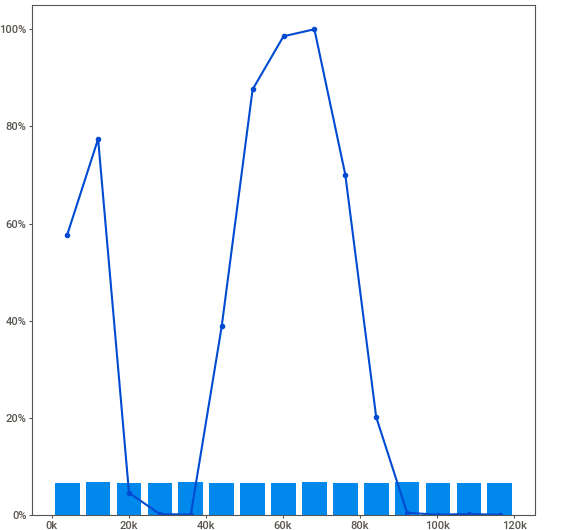
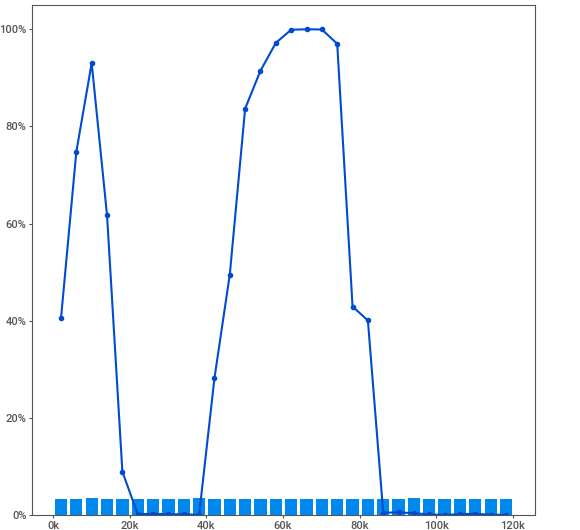
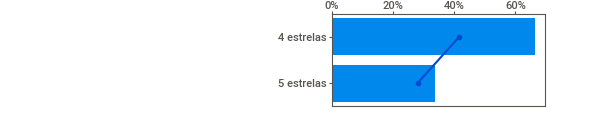
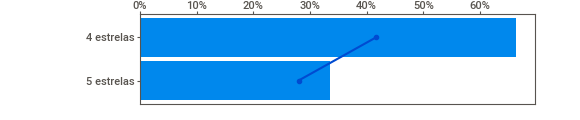
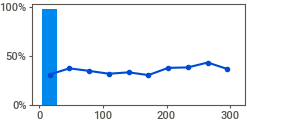
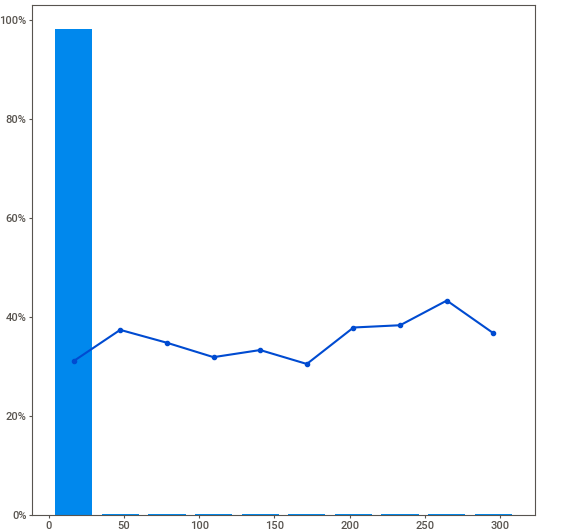
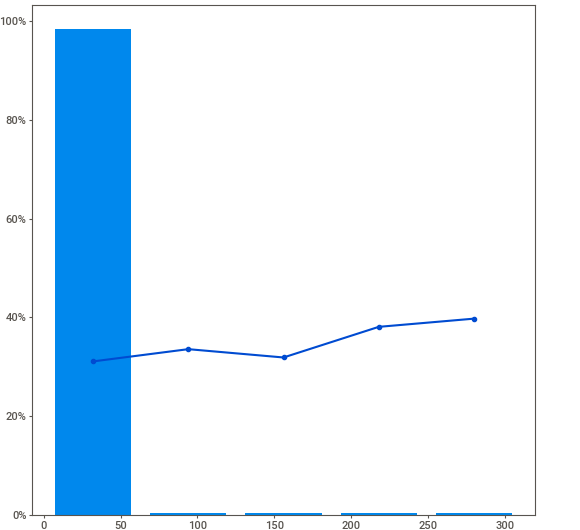
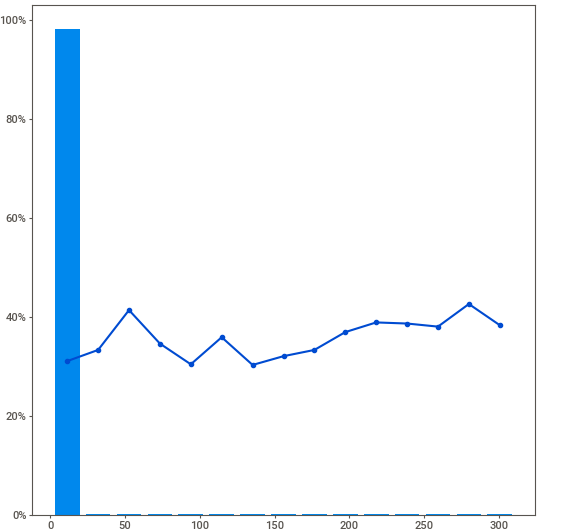
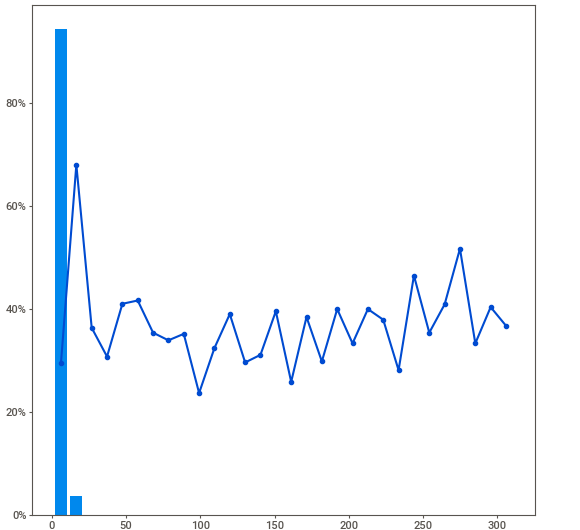
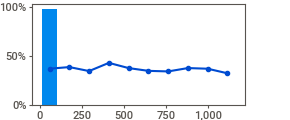
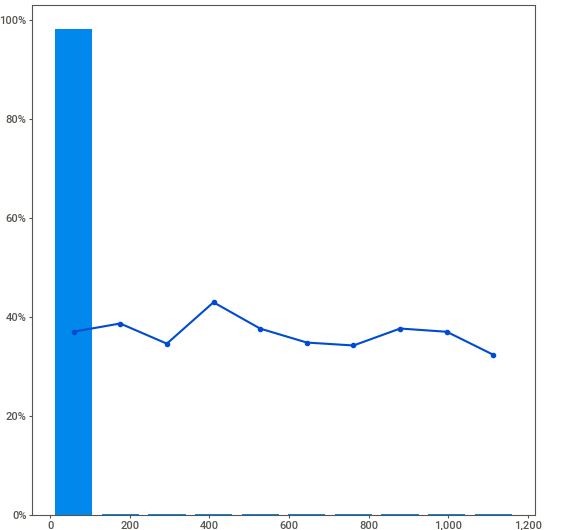
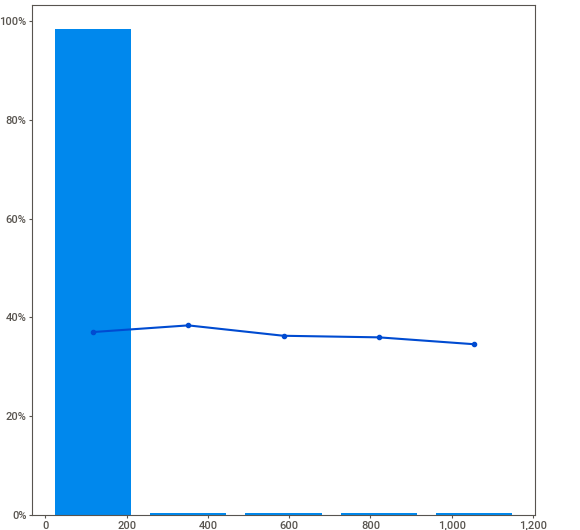
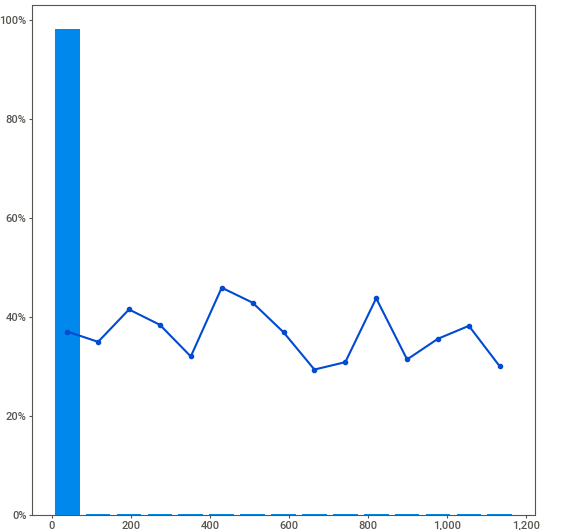
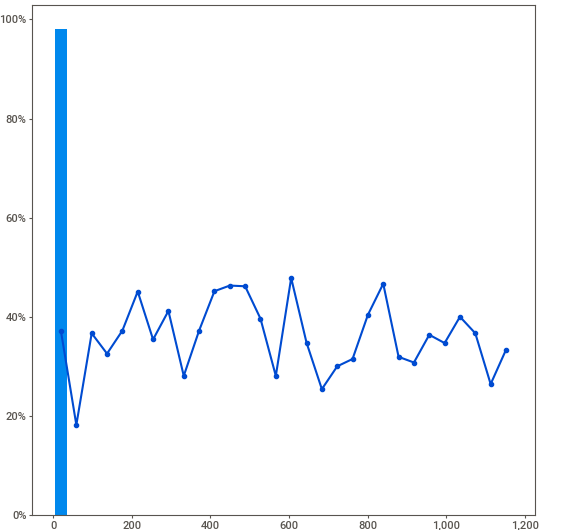
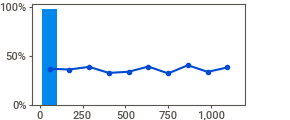
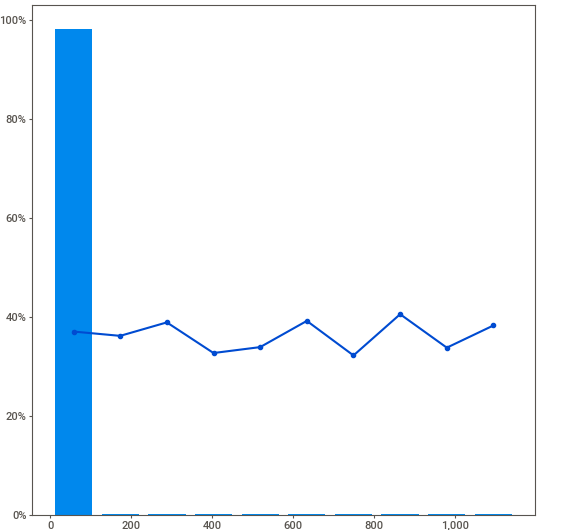
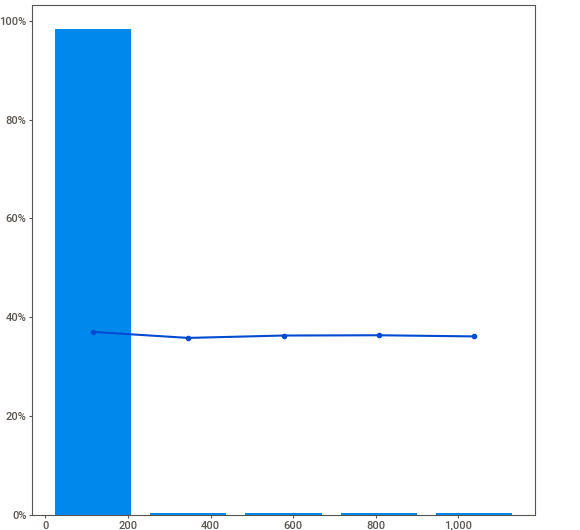
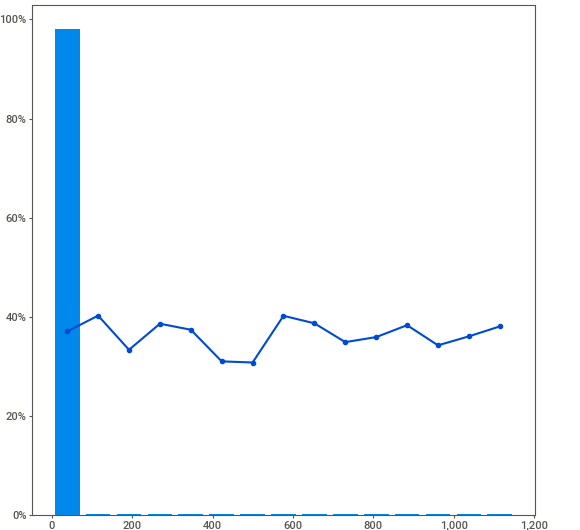
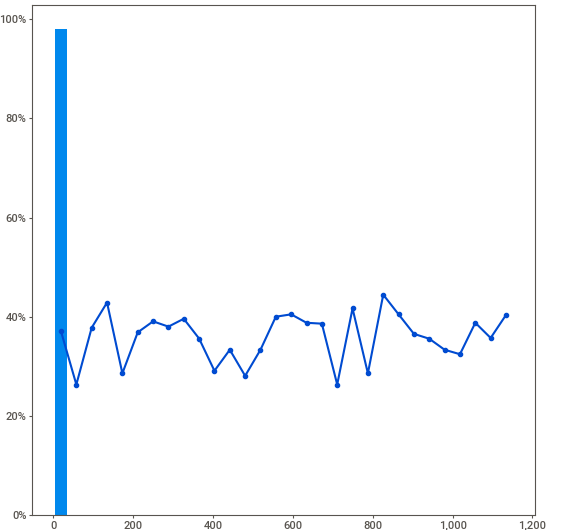
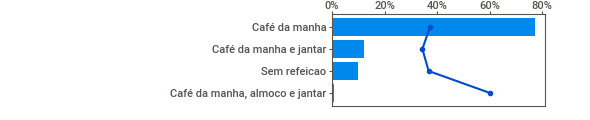
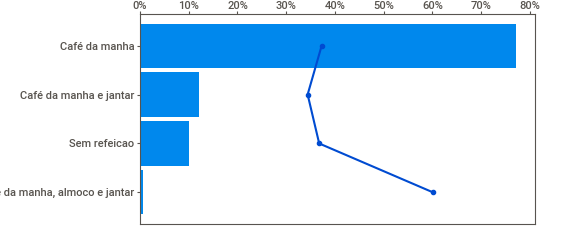
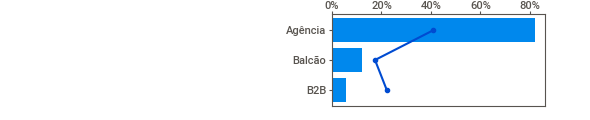
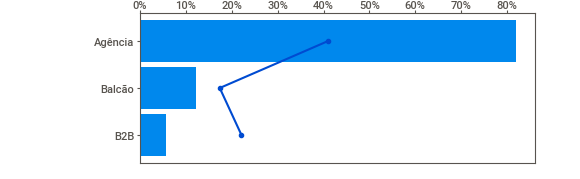
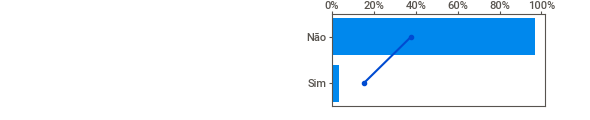
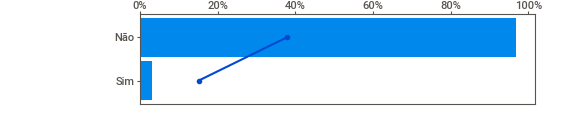
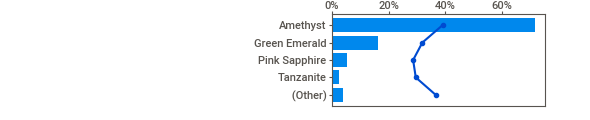
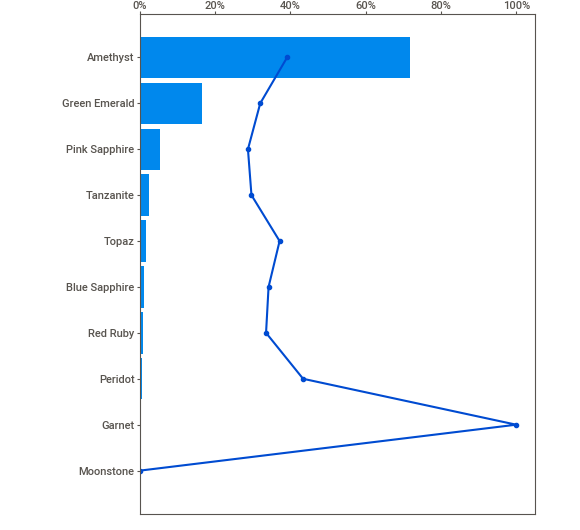
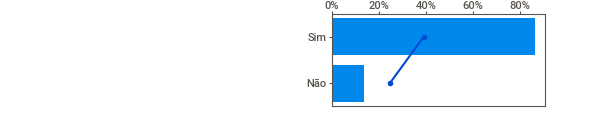
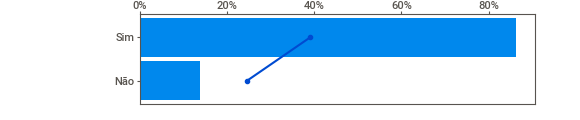
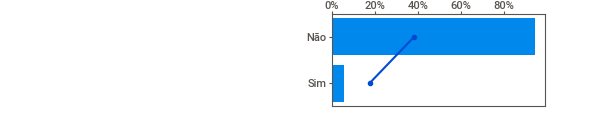
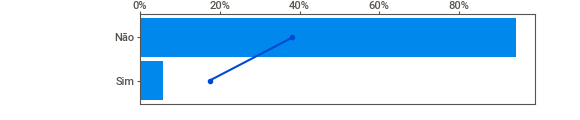
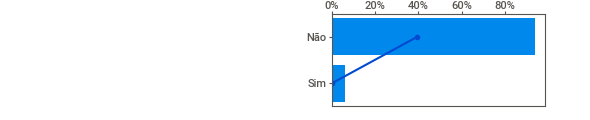
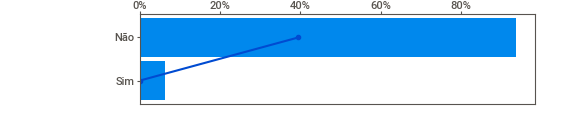
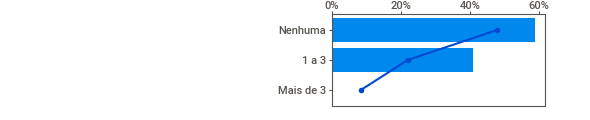
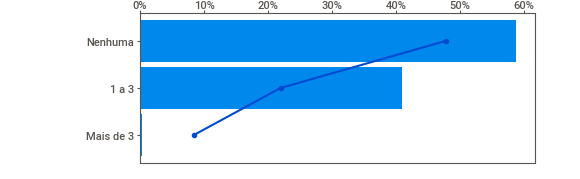
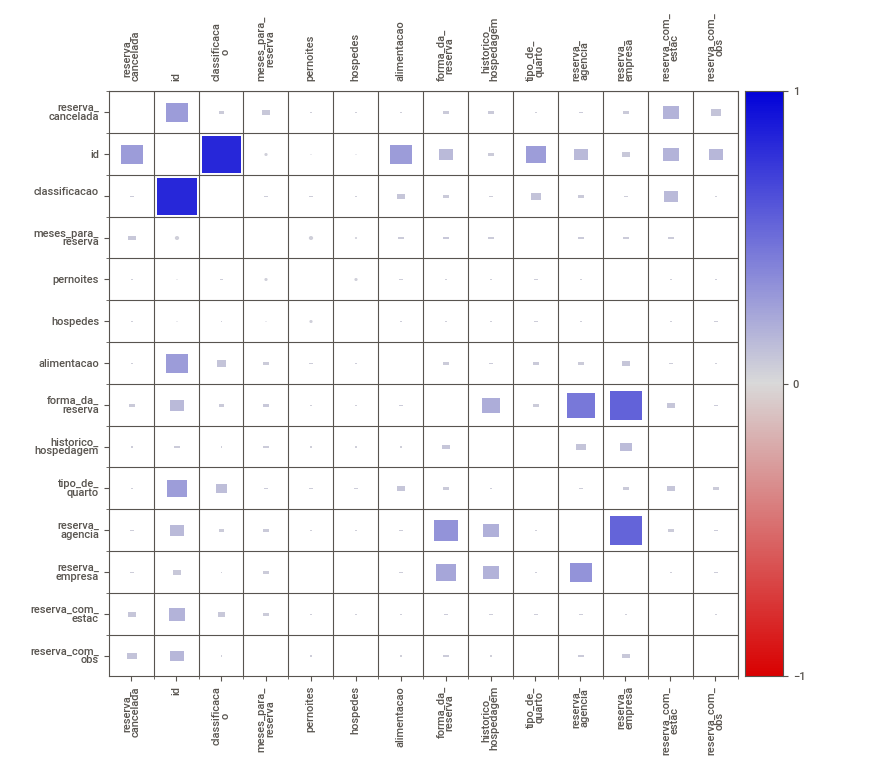
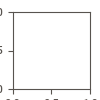

In [29]:
# Visualização com Sweetviz
feature_analysis = sv.analyze(df1, target_feat='reserva_cancelada')
feature_analysis.show_notebook()

In [147]:
df2 = df1
# Dividir os dados em features (X) e target (y)
X = df2.drop(['reserva_cancelada'], axis=1)
y = df2['reserva_cancelada']

# Dividir os dados em treino, teste e validação
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
data_train = pd.concat([X_train,y_train],axis=1)

In [148]:
X_train = fill_nas(X_train)
X_val = fill_nas(X_val)
X_test = fill_nas(X_test)

In [149]:
X_train.loc[X_train['hospedes']==0, 'hospedes'] = X_train['hospedes'].median()
X_val.loc[X_val['hospedes']==0, 'hospedes'] = X_val['hospedes'].median()
X_test.loc[X_test['hospedes']==0, 'hospedes'] = X_test['hospedes'].median()

In [150]:
UE = ['France', 'Belgium', 'Germany', 'Netherlands', 'Italy', 'Luxembourg', 'Austria', 'Switzerland', 'Poland', 'Greece', 'United Kingdom', 'Denmark']

X_train['tipo_hospede'] = X_train['nacionalidade'].apply(classificar_hospede)
X_val['tipo_hospede'] = X_val['nacionalidade'].apply(classificar_hospede)
X_test['tipo_hospede'] = X_test['nacionalidade'].apply(classificar_hospede)

In [151]:
X_train['historico_hospedagem'] = processar_coluna_sim_nao(X_train['historico_hospedagem'])
X_train['reserva_empresa'] = processar_coluna_sim_nao(X_train['reserva_empresa'])
X_val['historico_hospedagem'] = processar_coluna_sim_nao(X_val['historico_hospedagem'])
X_val['reserva_empresa'] = processar_coluna_sim_nao(X_val['reserva_empresa'])
X_test['historico_hospedagem'] = processar_coluna_sim_nao(X_test['historico_hospedagem'])
X_test['reserva_empresa'] = processar_coluna_sim_nao(X_test['reserva_empresa'])

In [152]:
X_train = encoder_df(X_train)
X_val = encoder_df(X_val)
X_test = encoder_df(X_test)

In [153]:
colunas_para_transformar = ['hospedes', 'meses_para_reserva', 'pernoites']

for coluna in colunas_para_transformar:
    X_train[coluna] = aplicar_log1p(X_train[coluna])
for coluna in colunas_para_transformar:
    X_val[coluna] = aplicar_log1p(X_val[coluna])
for coluna in colunas_para_transformar:
    X_test[coluna] = aplicar_log1p(X_test[coluna])

In [154]:
# Seleção de features com o método Boruta
#boruta_selector = BorutaPy(
 #   estimator=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=3520),
  #  n_estimators='auto',
   # verbose=2,
    #random_state=3520
#)
#boruta_selector.fit(X_train.values, y_train.values)

In [145]:
selected_features = X_train.columns[boruta_selector.support_].tolist()

In [146]:
print(selected_features)

['id', 'meses_para_reserva', 'pernoites', 'hospedes', 'alimentacao', 'nacionalidade', 'forma_da_reserva', 'historico_hospedagem', 'reserva_empresa', 'reserva_com_estac', 'reserva_com_obs', 'tipo_hospede']


In [156]:
#Eliminando as colunas com pouca importância
colls_drop = ['reserva_agencia', 'tipo_de_quarto', 'classificacao']
X_train_selected = X_train.drop(colls_drop, axis=1)
X_test_selected = X_test.drop(colls_drop, axis=1)
X_val_selected = X_val.drop(colls_drop, axis=1)

In [134]:
#Criando um dataframe com a classificação das variáveis pelo Boruta
ranking = boruta_selector.ranking_
ranking_df = pd.DataFrame({'Variável': X_train.columns, 'Ranking': ranking})
ranking_df.sort_values('Ranking', inplace=True)
print(ranking_df)

                Variável  Ranking
0                     id        1
2     meses_para_reserva        1
3              pernoites        1
4               hospedes        1
5            alimentacao        1
6          nacionalidade        1
7       forma_da_reserva        1
8   historico_hospedagem        1
11       reserva_empresa        1
12     reserva_com_estac        1
13       reserva_com_obs        1
14          tipo_hospede        1
10       reserva_agencia        2
9         tipo_de_quarto        3
1          classificacao        4


# Modelagem

In [157]:
# Modelos
xgb_model = xgb.XGBClassifier(n_estimators=600)
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [158]:
# Treinar modelos
xgb_model.fit(X_train_selected, y_train) 
et_model.fit(X_train_selected, y_train)
rf_model.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [159]:
for model, model_name in [(xgb_model, 'XGBoost'), (et_model, 'ExtraTrees'), (rf_model, 'RandomForest')]:
    y_test_pred = model.predict(X_test_selected)
    test_f1 = f1_score(y_test, y_test_pred)
    print(f"F1-score nos dados de teste - {model_name}: {test_f1:.4f}")

F1-score nos dados de teste - XGBoost: 0.9476
F1-score nos dados de teste - ExtraTrees: 0.9494
F1-score nos dados de teste - RandomForest: 0.9035


In [160]:
# Use o PyCaret para ajuste de hiperparâmetros
clf1 = setup(data=pd.concat([X_train_selected, y_train], axis=1), target='reserva_cancelada')  
best_model = compare_models(sort='F1')

,Description,Value
0,Session id,4453
1,Target,reserva_cancelada
2,Target type,Binary
3,Original data shape,"(50511, 13)"
4,Transformed data shape,"(50511, 13)"
5,Transformed train set shape,"(35357, 13)"
6,Transformed test set shape,"(15154, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9690,0.9959,0.9558,0.9607,0.9583,0.9336,0.9336,1.5550
rf,Random Forest Classifier,0.9678,0.9933,0.9582,0.9555,0.9568,0.9311,0.9312,1.3750
catboost,CatBoost Classifier,0.9639,0.9952,0.9509,0.9523,0.9516,0.9228,0.9229,9.6760
dt,Decision Tree Classifier,0.9626,0.9601,0.9505,0.9491,0.9498,0.9199,0.9199,0.1200
lightgbm,Light Gradient Boosting Machine,0.9624,0.9951,0.9499,0.9493,0.9496,0.9196,0.9196,0.9460
et,Extra Trees Classifier,0.9610,0.9856,0.9475,0.9478,0.9476,0.9166,0.9166,1.3420
gbc,Gradient Boosting Classifier,0.9501,0.9909,0.9406,0.9267,0.9336,0.8937,0.8937,1.4940
knn,K Neighbors Classifier,0.9422,0.9779,0.9248,0.9205,0.9226,0.8765,0.8765,0.1610
ada,Ada Boost Classifier,0.9313,0.9858,0.9327,0.8886,0.9101,0.8546,0.8553,0.6210
lda,Linear Discriminant Analysis,0.7710,0.8313,0.6531,0.7093,0.6800,0.5023,0.5033,0.0890


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [161]:
# Tunando modelo com PyCaret
tuned_model = tune_model(best_model) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9508,0.9957,0.9863,0.8928,0.9372,0.8969,0.8999
1,0.9519,0.9949,0.9841,0.8969,0.9385,0.8991,0.9017
2,0.9522,0.9951,0.9848,0.8970,0.9388,0.8998,0.9024
3,0.9508,0.9963,0.9909,0.8896,0.9375,0.8971,0.9007
4,0.9514,0.9957,0.9894,0.8919,0.9381,0.8982,0.9015
5,0.9511,0.9951,0.9856,0.8940,0.9376,0.8975,0.9004
6,0.9559,0.9973,0.9939,0.8985,0.9438,0.9076,0.9108
7,0.9479,0.9959,0.9924,0.8825,0.9342,0.8914,0.8956
8,0.9522,0.9960,0.9894,0.8937,0.9391,0.8999,0.9031


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [162]:
#Criando variável com melhores parâmetros
best_params = tuned_model.get_params()
print(best_params)

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 4453, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'auto', 'validate_parameters': None, 'verbosity': 0}


In [163]:
# Prever os resultados nos dados de validação e calcular F1-score
y_val_pred_tuned = tuned_model.predict(X_val_selected) 
val_f1_tuned = f1_score(y_val, y_val_pred_tuned)
print(f"F1-score nos dados de validação com modelo tunado: {val_f1_tuned:.4f}")

F1-score nos dados de validação com modelo tunado: 0.9494


In [164]:
# Carregar os dados de teste para submissão
df_test = pd.read_csv('/kaggle/input/cdshackdays4/test.csv') 
df_test = rename_columns(df_test, new_names) 

In [166]:
# Aplicando transformações no dataset de teste
df_test = rename_columns(df_test, new_names)
df_test = fill_nas(df_test)
df_test.loc[df_test['hospedes']==0, 'hospedes'] = df_test['hospedes'].median()
df_test['tipo_hospede'] = df_test['nacionalidade'].apply(classificar_hospede)
df_test['historico_hospedagem'] = processar_coluna_sim_nao(df_test['historico_hospedagem'])
df_test['reserva_empresa'] = processar_coluna_sim_nao(df_test['reserva_empresa'])
df_test = encoder_df(df_test)
for coluna in colunas_para_transformar:
    df_test[coluna] = aplicar_log1p(df_test[coluna])

In [167]:
# Aplicar seleção de recursos no conjunto de teste usando o Boruta
df_test_selected = df_test.drop(colls_drop, axis=1)

In [168]:
# Fazer previsões no conjunto de teste usando o modelo treinado
predictions = tuned_model.predict(df_test_selected)

In [170]:
# Preparar submissão
df_submission = pd.read_csv('/kaggle/input/cdshackdays4/submission.csv') 
df_submission['reserva_cancelada'] = predictions
df_submission.to_csv('submission.csv', index=False)